# PCA, AE COMPARE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [3]:
# Perform PCA with first 30 components
pca = PCA(n_components=30)
x_train_pca = pca.fit_transform(x_train)
x_train_reconstructed_pca = pca.inverse_transform(x_train_pca)

# Reconstruction error for PCA
pca_reconstruction_error = mean_squared_error(x_train, x_train_reconstructed_pca)
print(f"PCA Reconstruction MSE: {pca_reconstruction_error}")

PCA Reconstruction MSE: 0.018121110275387764


In [4]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 30),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),  # Sigmoid to output pixel values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [5]:
# Train the Autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, device=device)
x_test_tensor = torch.tensor(x_test, device=device)

# Training loop
num_epochs = 20
batch_size = 256
train_loader = torch.utils.data.DataLoader(x_train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.0472
Epoch [2/20], Loss: 0.0320
Epoch [3/20], Loss: 0.0251
Epoch [4/20], Loss: 0.0225
Epoch [5/20], Loss: 0.0191
Epoch [6/20], Loss: 0.0180
Epoch [7/20], Loss: 0.0181
Epoch [8/20], Loss: 0.0127
Epoch [9/20], Loss: 0.0150
Epoch [10/20], Loss: 0.0134
Epoch [11/20], Loss: 0.0124
Epoch [12/20], Loss: 0.0118
Epoch [13/20], Loss: 0.0105
Epoch [14/20], Loss: 0.0106
Epoch [15/20], Loss: 0.0110
Epoch [16/20], Loss: 0.0108
Epoch [17/20], Loss: 0.0098
Epoch [18/20], Loss: 0.0096
Epoch [19/20], Loss: 0.0100
Epoch [20/20], Loss: 0.0085


In [6]:
x_train_reconstructed_ae = model(x_train_tensor).cpu().detach().numpy()

In [7]:
# Reconstruction error
ae_reconstruction_error = mean_squared_error(x_train, x_train_reconstructed_ae)
print(f"Autoencoder Reconstruction MSE: {ae_reconstruction_error}")

Autoencoder Reconstruction MSE: 0.008910472504794598


In [8]:
# Compare PCA,  Autoencoder Reconstruction
print(f"Reconstruction MSE - PCA: {pca_reconstruction_error}")
print(f"Reconstruction MSE - Autoencoder: {ae_reconstruction_error}")


Reconstruction MSE - PCA: 0.018121110275387764
Reconstruction MSE - Autoencoder: 0.008910472504794598


# Standard Autoencoder

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

#  Define Under-complete Autoencoder
class UndercompleteAE(nn.Module):
    def __init__(self, hidden_dim):
        super(UndercompleteAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 784),
            nn.Sigmoid()  # o/p pixel values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
#  Function to train Autoencoder
def train_autoencoder(hidden_dim, num_epochs=10):
    model = UndercompleteAE(hidden_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader = torch.utils.data.DataLoader(x_train_tensor, batch_size=256, shuffle=True)

    for epoch in range(num_epochs):
        for data in train_loader:
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


In [11]:
# Training for different hidden dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train_tensor = torch.tensor(x_train, device=device)

hidden_dims = [64, 128, 256]
models = {}
reconstructions = {}

for hidden_dim in hidden_dims:
    print(f"Training AE with hidden layer size: {hidden_dim}")
    model = train_autoencoder(hidden_dim)
    models[hidden_dim] = model

    # Reconstruct a test image
    test_image = torch.tensor(x_test[0], device=device).unsqueeze(0)
    reconstructed_image = model(test_image).cpu().detach().numpy().reshape(28, 28)

    reconstructions[hidden_dim] = reconstructed_image


Training AE with hidden layer size: 64
Epoch [1/10], Loss: 0.0381
Epoch [2/10], Loss: 0.0257
Epoch [3/10], Loss: 0.0186
Epoch [4/10], Loss: 0.0133
Epoch [5/10], Loss: 0.0103
Epoch [6/10], Loss: 0.0096
Epoch [7/10], Loss: 0.0077
Epoch [8/10], Loss: 0.0073
Epoch [9/10], Loss: 0.0065
Epoch [10/10], Loss: 0.0071
Training AE with hidden layer size: 128
Epoch [1/10], Loss: 0.0273
Epoch [2/10], Loss: 0.0158
Epoch [3/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0081
Epoch [5/10], Loss: 0.0061
Epoch [6/10], Loss: 0.0051
Epoch [7/10], Loss: 0.0045
Epoch [8/10], Loss: 0.0036
Epoch [9/10], Loss: 0.0034
Epoch [10/10], Loss: 0.0030
Training AE with hidden layer size: 256
Epoch [1/10], Loss: 0.0208
Epoch [2/10], Loss: 0.0116
Epoch [3/10], Loss: 0.0065
Epoch [4/10], Loss: 0.0047
Epoch [5/10], Loss: 0.0038
Epoch [6/10], Loss: 0.0033
Epoch [7/10], Loss: 0.0027
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0023
Epoch [10/10], Loss: 0.0021


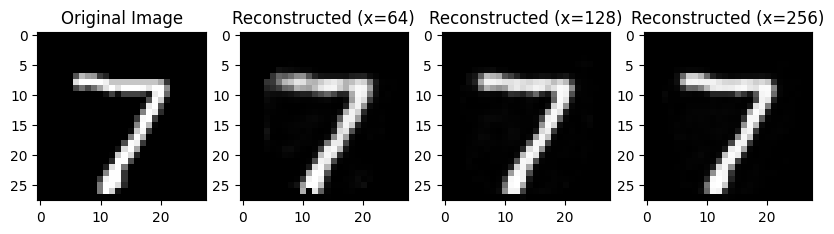

In [12]:
# Plotting the reconstruction results
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
for i, hidden_dim in enumerate(hidden_dims):
    plt.subplot(1, 4, i+2)
    plt.title(f"Reconstructed (x={hidden_dim})")
    plt.imshow(reconstructions[hidden_dim], cmap='gray')
plt.show()



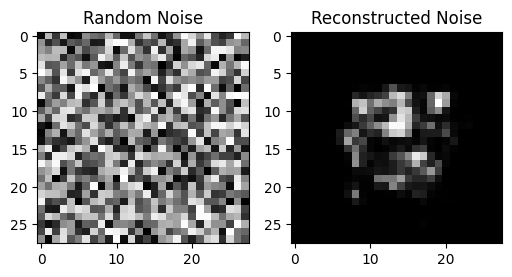

In [13]:
# Pass random noise images
noise_image = np.random.rand(28, 28).astype(np.float32)
noise_image_tensor = torch.tensor(noise_image.flatten(), device=device).unsqueeze(0)
noise_reconstruction = model(noise_image_tensor).cpu().detach().numpy().reshape(28, 28)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Random Noise")
plt.imshow(noise_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Noise")
plt.imshow(noise_reconstruction, cmap='gray')
plt.show()


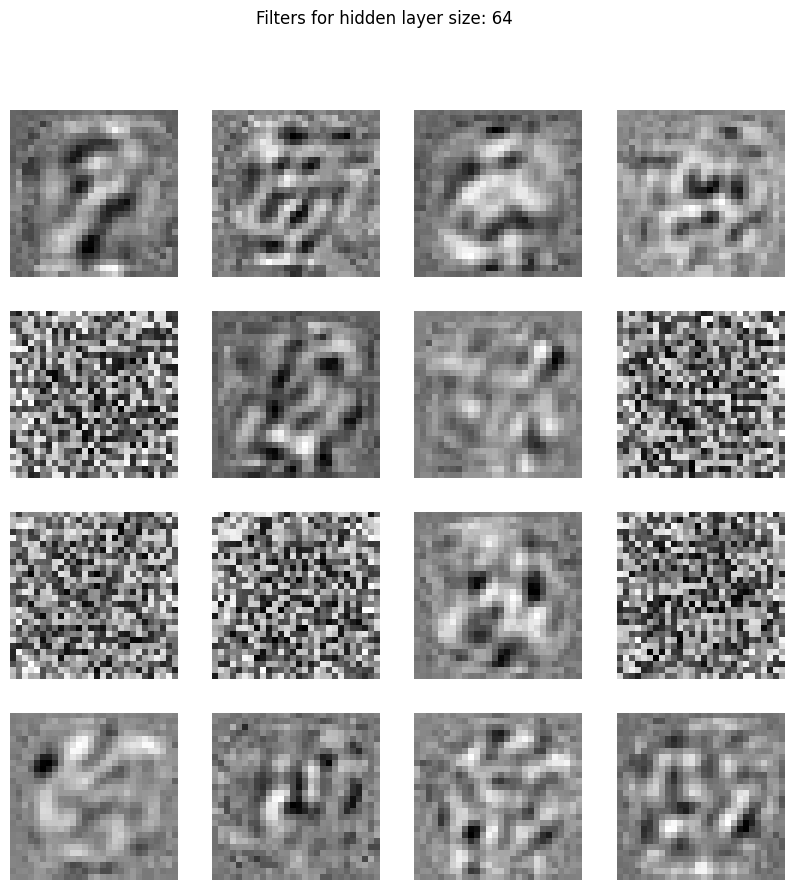

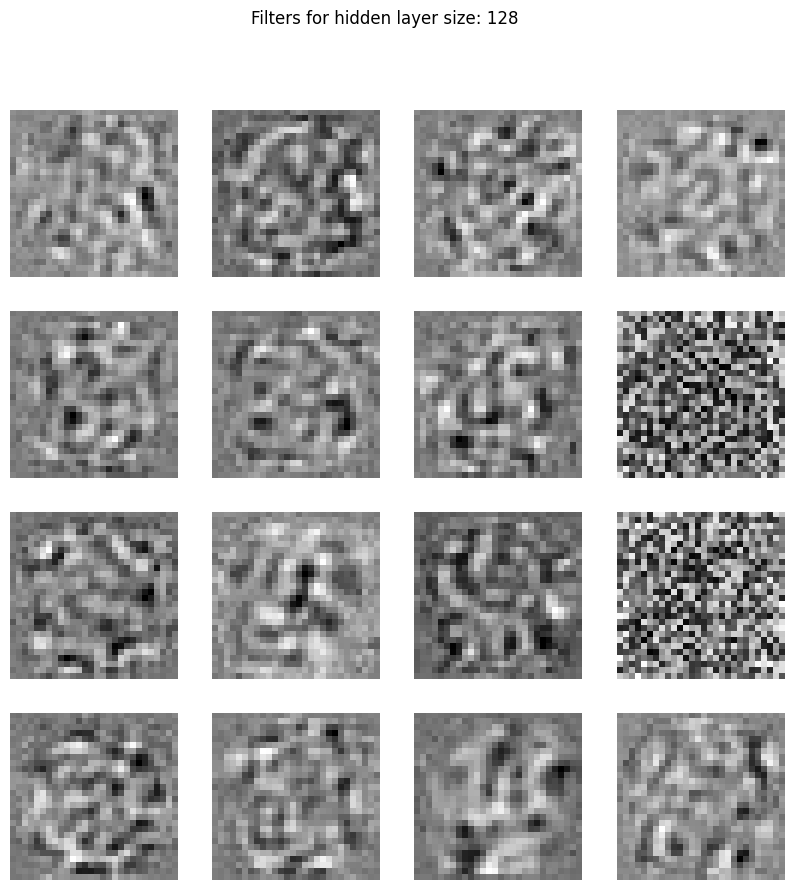

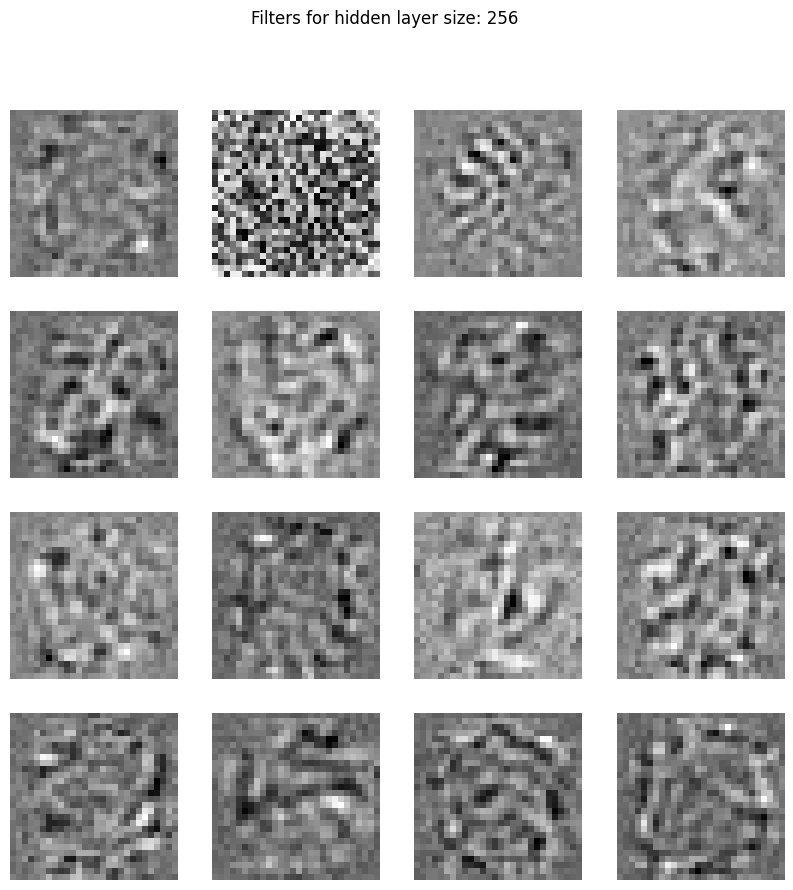

In [14]:
# Visualising learned filters
for hidden_dim in hidden_dims:
    model = models[hidden_dim]
    encoder_weights = model.encoder[0].weight.cpu().detach().numpy()

    # Plot filters as images
    plt.figure(figsize=(10, 10))
    for i in range(16):  # Visualize first 16 filters
        plt.subplot(4, 4, i+1)
        plt.imshow(encoder_weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Filters for hidden layer size: {hidden_dim}")
    plt.show()


# Sparse Autoencoders

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

# Convert to tensors
x_train_tensor = torch.tensor(x_train, device='cuda' if torch.cuda.is_available() else 'cpu')
x_test_tensor = torch.tensor(x_test, device='cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Define Over-complete Autoencoder with Sparsity Regularization
class SparseAutoencoder(nn.Module):
    def __init__(self, hidden_dim, sparsity_param=1e-5):
        super(SparseAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 784),
            nn.Sigmoid()
        )
        # Sparsity regularization param
        self.sparsity_param = sparsity_param

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    # L1 regularization on hidden layer activations
    def l1_penalty(self, encoded):
        return self.sparsity_param * torch.sum(torch.abs(encoded))


In [17]:
# Train
def train_sparse_ae(hidden_dim, sparsity_param=1e-5, num_epochs=10):
    model = SparseAutoencoder(hidden_dim, sparsity_param).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader = torch.utils.data.DataLoader(x_train_tensor, batch_size=256, shuffle=True)

    for epoch in range(num_epochs):
        for data in train_loader:
            outputs, encoded = model(data)
            loss = criterion(outputs, data) + model.l1_penalty(encoded)  # Add L1 penalty on hidden layer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


In [18]:
def compare_activations_and_filters(hidden_dim=1024, sparsity_params=[1e-5, 1e-4, 1e-3]):
    # Train Standard AE
    standard_model = SparseAutoencoder(hidden_dim, sparsity_param=0).to(device)  # No sparsity
    standard_model = train_sparse_ae(hidden_dim, sparsity_param=0)

    # Train Sparse AEs with different sparsity params
    sparse_models = {}
    for sparsity_param in sparsity_params:
        print(f"\nTraining Sparse AE with sparsity_param={sparsity_param}")
        sparse_model = train_sparse_ae(hidden_dim, sparsity_param)
        sparse_models[sparsity_param] = sparse_model

    # Compare average hidden layer activations for standard vs sparse
    test_image = torch.tensor(x_test[0], device=device).unsqueeze(0)

    _, standard_encoded = standard_model(test_image)
    standard_avg_activation = torch.mean(torch.abs(standard_encoded)).item()

    print(f"Standard AE average activation: {standard_avg_activation:.4f}")

    for sparsity_param, model in sparse_models.items():
        _, sparse_encoded = model(test_image)
        sparse_avg_activation = torch.mean(torch.abs(sparse_encoded)).item()
        print(f"Sparse AE (sparsity={sparsity_param}) average activation: {sparse_avg_activation:.4f}")

    # Visualize filters (encoder weights)
    visualize_filters(standard_model, "Standard AE Filters")

    for sparsity_param, model in sparse_models.items():
        visualize_filters(model, f"Sparse AE Filters (sparsity={sparsity_param})")


In [19]:
def visualize_filters(model, title):
    encoder_weights = model.encoder[0].weight.cpu().detach().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(16):  # Visualize first 16 filters
        plt.subplot(4, 4, i+1)
        plt.imshow(encoder_weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch [1/10], Loss: 0.0149
Epoch [2/10], Loss: 0.0082
Epoch [3/10], Loss: 0.0065
Epoch [4/10], Loss: 0.0058
Epoch [5/10], Loss: 0.0044
Epoch [6/10], Loss: 0.0048
Epoch [7/10], Loss: 0.0042
Epoch [8/10], Loss: 0.0043
Epoch [9/10], Loss: 0.0042
Epoch [10/10], Loss: 0.0030

Training Sparse AE with sparsity_param=1e-05
Epoch [1/10], Loss: 0.1926
Epoch [2/10], Loss: 0.1622
Epoch [3/10], Loss: 0.1395
Epoch [4/10], Loss: 0.1234
Epoch [5/10], Loss: 0.1118
Epoch [6/10], Loss: 0.1027
Epoch [7/10], Loss: 0.0950
Epoch [8/10], Loss: 0.0918
Epoch [9/10], Loss: 0.0872
Epoch [10/10], Loss: 0.0815

Training Sparse AE with sparsity_param=0.0001
Epoch [1/10], Loss: 0.1926
Epoch [2/10], Loss: 0.1632
Epoch [3/10], Loss: 0.1407
Epoch [4/10], Loss: 0.1226
Epoch [5/10], Loss: 0.1127
Epoch [6/10], Loss: 0.1019
Epoch [7/10], Loss: 0.0946
Epoch [8/10], Loss: 0.0889
Epoch [9/10], Loss: 0.0874
Epoch [10/10], Loss: 0.0846

Training Sparse AE with sparsity_param=0.001
Epoch [1/10], Loss: 0.1932
Epoch [2/10], Loss: 0

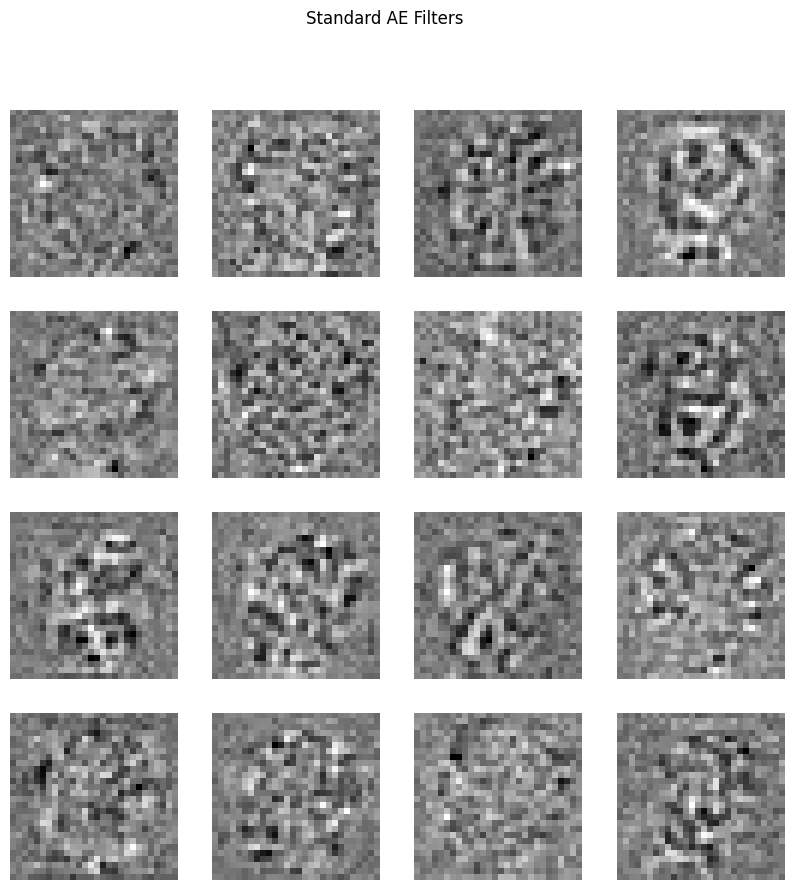

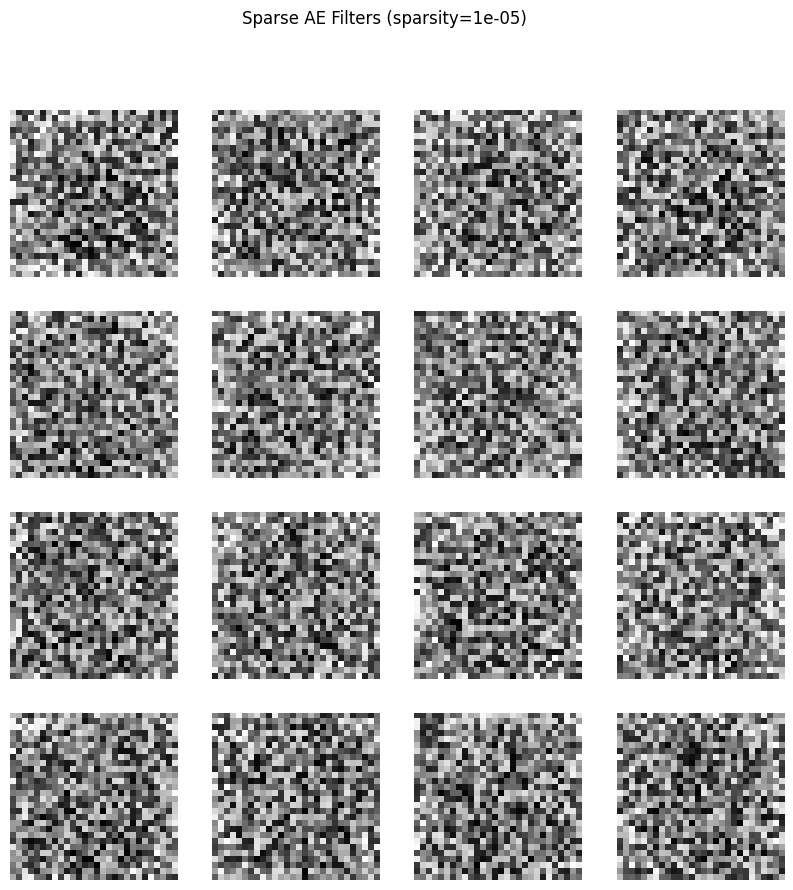

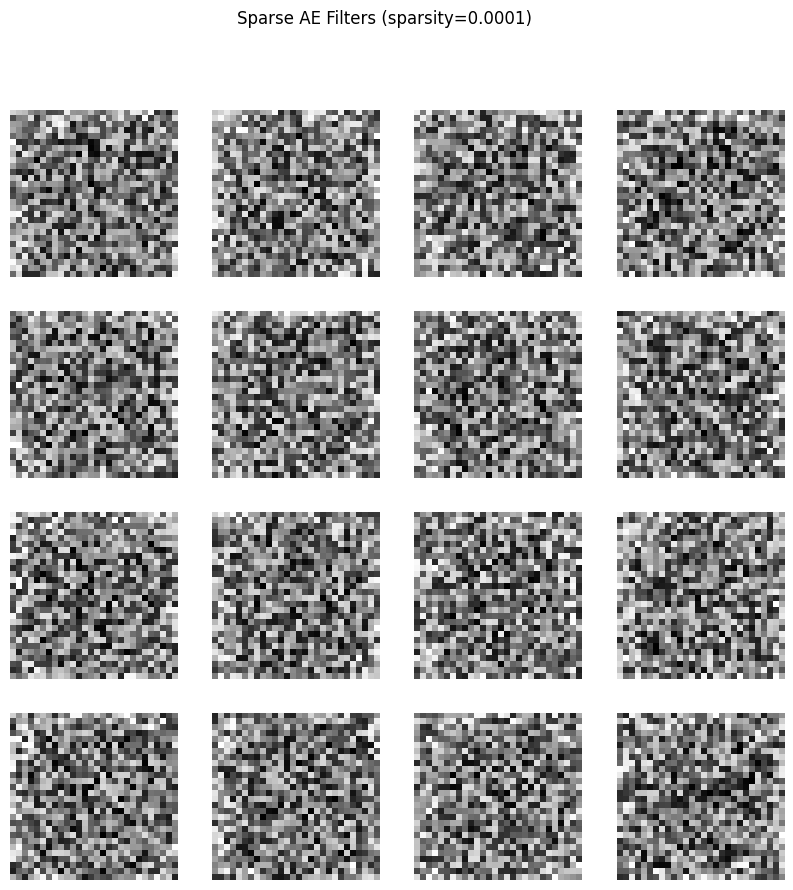

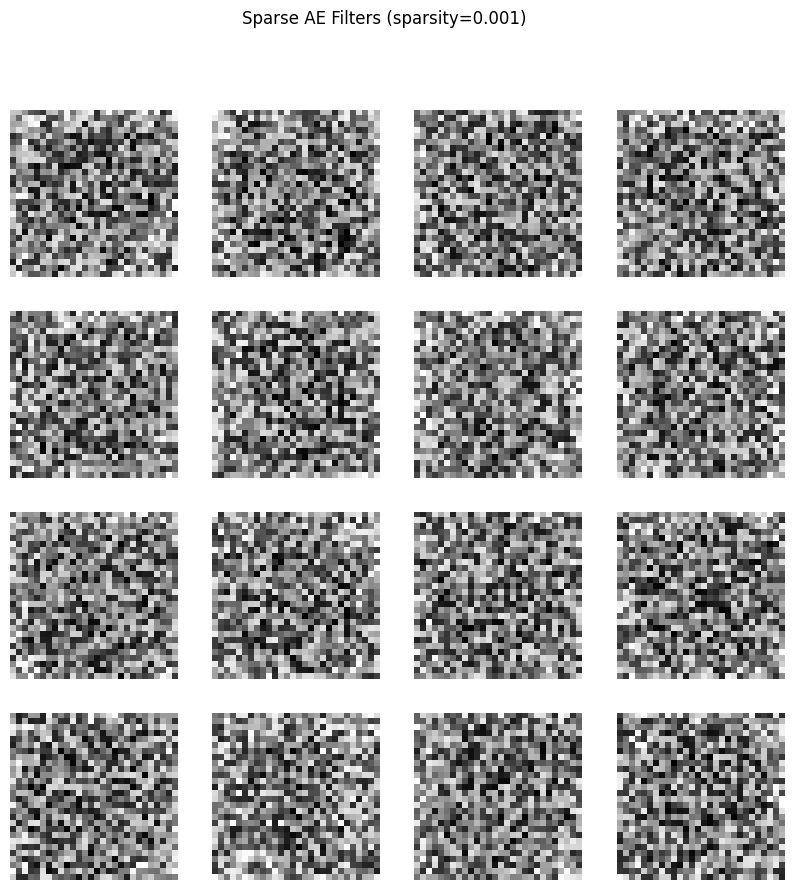

In [20]:
compare_activations_and_filters()


# Denoising Autoencoders

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

x_train_tensor = torch.tensor(x_train, device='cuda' if torch.cuda.is_available() else 'cpu')
x_test_tensor = torch.tensor(x_test, device='cuda' if torch.cuda.is_available() else 'cpu')

# Define Denoising Autoencoder with just 1 hidden unit
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to add noise
def add_noise(images, noise_level):
    noise = noise_level * torch.randn(images.shape).to(images.device)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)


In [22]:
def train_denoising_ae(noise_level, num_epochs=10):
    model = DenoisingAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader = torch.utils.data.DataLoader(x_train_tensor, batch_size=256, shuffle=True)

    for epoch in range(num_epochs):
        for data in train_loader:
            # Add noise to the images
            noisy_data = add_noise(data, noise_level)
            # Forward pass
            outputs = model(noisy_data)
            loss = criterion(outputs, data)  # Compare reconstruction with clean data

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

# Test function to compare reconstruction of noisy images with standard AE
def test_noisy_images_on_standard_ae(model, noise_level):
    # Add noise to test images
    noisy_images = add_noise(x_test_tensor, noise_level)
    # Get reconstruction from standard AE
    reconstructed_images = model(noisy_images)  # No need to unpack
    return noisy_images, reconstructed_images

#  Compare and visualize reconstructions
def compare_reconstructions(standard_ae, noise_levels):
    for noise_level in noise_levels:
        print(f"Testing with noise level: {noise_level}")

        # Train denoising AE
        denoising_ae = train_denoising_ae(noise_level)

        # Get a noisy image and its reconstruction from both AEs
        noisy_image = add_noise(x_test_tensor[0:1], noise_level)
        denoised_output = denoising_ae(noisy_image)[0]
        standard_output = standard_ae(noisy_image)  # Fix here

        # Plot original, noisy, denoised, and standard AE output
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(noisy_image.cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.title(f"Noisy Image (Noise={noise_level})")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(denoised_output.cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(standard_output.cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.title("Standard AE Output")
        plt.axis('off')

        plt.show()

# Visualize learned filters (encoder weights)
def visualize_filters(model, title):
    encoder_weights = model.encoder[0].weight.cpu().detach().numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(encoder_weights.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


Testing with noise level: 0.3
Epoch [1/10], Loss: 0.1865
Epoch [2/10], Loss: 0.1155
Epoch [3/10], Loss: 0.0705
Epoch [4/10], Loss: 0.0678
Epoch [5/10], Loss: 0.0672
Epoch [6/10], Loss: 0.0632
Epoch [7/10], Loss: 0.0653
Epoch [8/10], Loss: 0.0638
Epoch [9/10], Loss: 0.0646
Epoch [10/10], Loss: 0.0647


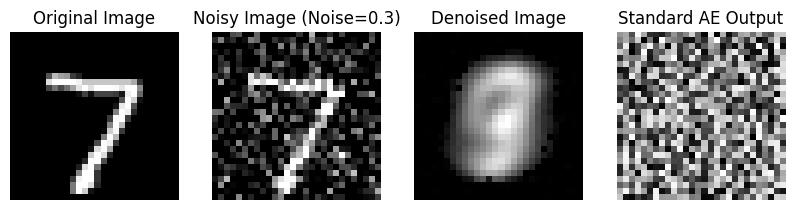

Testing with noise level: 0.5
Epoch [1/10], Loss: 0.2120
Epoch [2/10], Loss: 0.1814
Epoch [3/10], Loss: 0.1559
Epoch [4/10], Loss: 0.1363
Epoch [5/10], Loss: 0.1233
Epoch [6/10], Loss: 0.1100
Epoch [7/10], Loss: 0.1004
Epoch [8/10], Loss: 0.0965
Epoch [9/10], Loss: 0.0902
Epoch [10/10], Loss: 0.0832


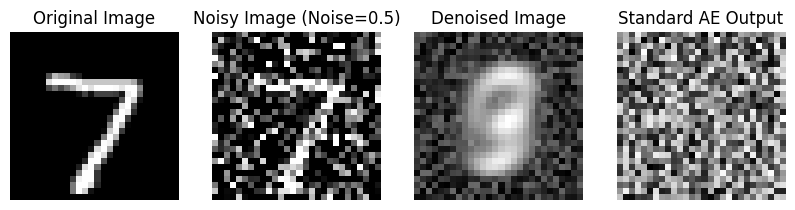

Testing with noise level: 0.8
Epoch [1/10], Loss: 0.1754
Epoch [2/10], Loss: 0.1087
Epoch [3/10], Loss: 0.0721
Epoch [4/10], Loss: 0.0691
Epoch [5/10], Loss: 0.0663
Epoch [6/10], Loss: 0.0637
Epoch [7/10], Loss: 0.0629
Epoch [8/10], Loss: 0.0668
Epoch [9/10], Loss: 0.0660
Epoch [10/10], Loss: 0.0666


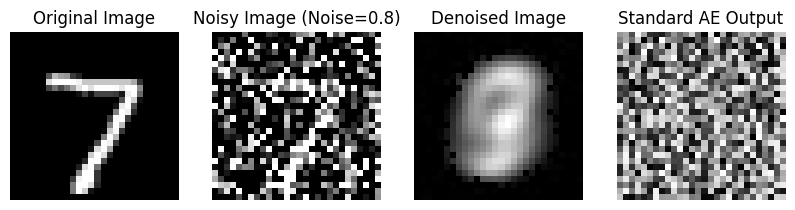

Testing with noise level: 0.9
Epoch [1/10], Loss: 0.2149
Epoch [2/10], Loss: 0.1839
Epoch [3/10], Loss: 0.1573
Epoch [4/10], Loss: 0.1403
Epoch [5/10], Loss: 0.1230
Epoch [6/10], Loss: 0.1109
Epoch [7/10], Loss: 0.1027
Epoch [8/10], Loss: 0.0986
Epoch [9/10], Loss: 0.0916
Epoch [10/10], Loss: 0.0855


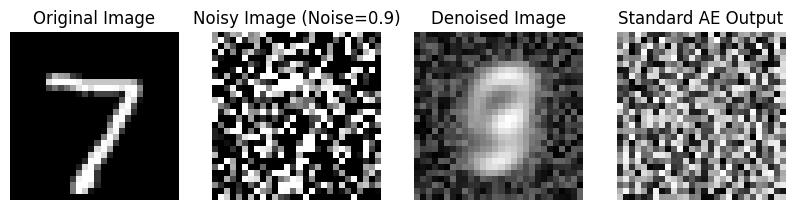

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

noise_levels = [0.3, 0.5, 0.8, 0.9]
standard_ae = DenoisingAutoencoder().to(device)

compare_reconstructions(standard_ae, noise_levels)


# Manifold Learning

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()  # To scale output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

transform = transforms.ToTensor()
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4604196.61it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 135289.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1097280.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5150183.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [25]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_autoencoder(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, _ in train_loader:
            images = images.view(-1, 784).to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_autoencoder(num_epochs=20)


Epoch [1/20], Loss: 0.0312
Epoch [2/20], Loss: 0.0271
Epoch [3/20], Loss: 0.0336
Epoch [4/20], Loss: 0.0309
Epoch [5/20], Loss: 0.0262
Epoch [6/20], Loss: 0.0244
Epoch [7/20], Loss: 0.0267
Epoch [8/20], Loss: 0.0247
Epoch [9/20], Loss: 0.0204
Epoch [10/20], Loss: 0.0225
Epoch [11/20], Loss: 0.0222
Epoch [12/20], Loss: 0.0226
Epoch [13/20], Loss: 0.0227
Epoch [14/20], Loss: 0.0243
Epoch [15/20], Loss: 0.0239
Epoch [16/20], Loss: 0.0194
Epoch [17/20], Loss: 0.0201
Epoch [18/20], Loss: 0.0222
Epoch [19/20], Loss: 0.0211
Epoch [20/20], Loss: 0.0203


In [26]:
def add_noise_to_latent_space(latent_rep, noise_factor=0.1):
    noise = torch.randn_like(latent_rep) * noise_factor
    return latent_rep + noise

def test_autoencoder_with_noise(noise_factor=0.1):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, 784).to(device)
            # Get latent representation
            latent_rep = model.encoder(images)
            # Add noise to latent representation
            noisy_latent_rep = add_noise_to_latent_space(latent_rep, noise_factor)
            # Reconstruct from noisy latent representation
            reconstructed = model.decoder(noisy_latent_rep)

            # Plot original image, noisy latent reconstruction
            plt.figure(figsize=(8, 4))
            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(images.cpu().view(28, 28), cmap='gray')
            plt.title("Original Image")
            plt.axis('off')

            # Reconstructed image
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
            plt.title(f"Reconstructed with Noise: {noise_factor}")
            plt.axis('off')

            plt.show()
            break  # We only test on the first image for demonstration




Testing with noise factor: 0.1


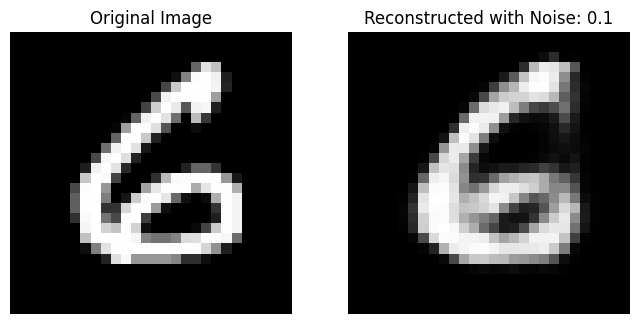


Testing with noise factor: 0.3


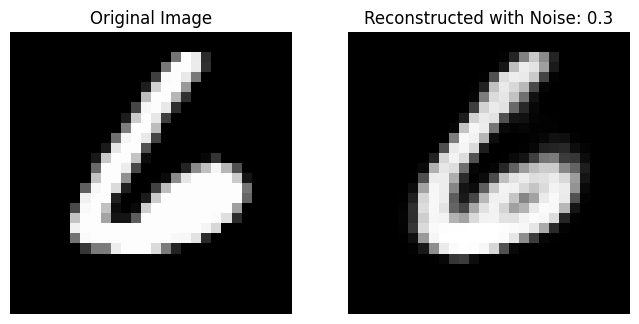


Testing with noise factor: 0.5


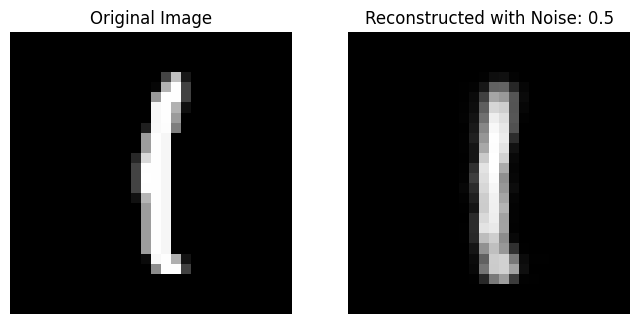

In [27]:
# Test the autoencoder with different noise levels in the latent space
for noise_factor in [0.1, 0.3, 0.5]:
    print(f"\nTesting with noise factor: {noise_factor}")
    test_autoencoder_with_noise(noise_factor=noise_factor)

4. Relation to Manifold Learning:
The key observation here is that the autoencoder learns a compact, low-dimensional representation (manifold) of the data. Valid digit representations are confined to this manifold, and deviations from this space (either through random noise in the input space or latent space) result in images that don't resemble valid digits.

This aligns with the concept of manifold learning, where the data lies on a lower-dimensional structure within a higher-dimensional space. AEs implicitly learn this structure by encoding valid images onto this lower-dimensional manifold (latent space), and the decoder reconstructs valid images only when the input is close to this manifold.

# CONVOLUTION AUTOENCODERS

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the Convolutional Autoencoder architecture
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)  # Conv1
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 2x2 Max Pooling

        self.encoder_conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # Conv2
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 2x2 Max Pooling

        self.encoder_conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)  # Conv3
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 2x2 Max Pooling

        # Decoder (Mirrored structure of encoder)
        self.unpool3 = nn.MaxUnpool2d(2, stride=2)  # Unpooling layer for Conv3
        self.decoder_conv3 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1)  # Deconv3

        self.unpool2 = nn.MaxUnpool2d(2, stride=2)  # Unpooling layer for Conv2
        self.decoder_conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1)  # Deconv2

        self.unpool1 = nn.MaxUnpool2d(2, stride=2)  # Unpooling layer for Conv1
        self.decoder_conv1 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1)  # Deconv1

    def forward(self, x):
        # Encoder forward pass
        size1 = x.size()
        x = F.relu(self.encoder_conv1(x))
        x, indices1 = self.pool1(x)

        size2 = x.size()
        x = F.relu(self.encoder_conv2(x))
        x, indices2 = self.pool2(x)

        size3 = x.size()
        x = F.relu(self.encoder_conv3(x))
        x, indices3 = self.pool3(x)

        encoded = x  # Encoded representation

        # Decoder forward pass
        x = self.unpool3(x, indices3, output_size=size3)
        x = F.relu(self.decoder_conv3(x))

        x = self.unpool2(x, indices2, output_size=size2)
        x = F.relu(self.decoder_conv2(x))

        x = self.unpool1(x, indices1, output_size=size1)
        x = torch.sigmoid(self.decoder_conv1(x))

        decoded = x  # Decoded (reconstructed) output
        return encoded, decoded


In [30]:
# Instantiate the model, loss function, and optimizer
model = ConvolutionalAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(-1, 1, 28, 28)

        # Forward pass
        encoded, outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.0075
Epoch [2/5], Loss: 0.0049
Epoch [3/5], Loss: 0.0043
Epoch [4/5], Loss: 0.0037
Epoch [5/5], Loss: 0.0037


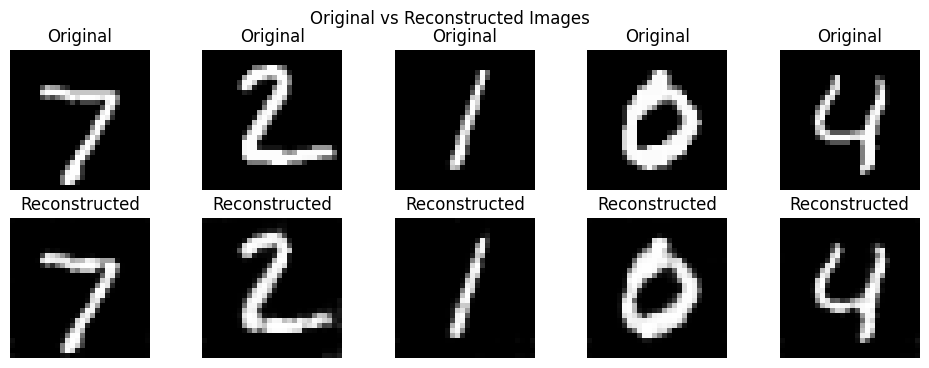

In [31]:
import torch
import matplotlib.pyplot as plt

def test_convolutional_autoencoder(model, test_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch in test_loader:
            inputs, _ = batch
            inputs = inputs.view(-1, 1, 28, 28)

            # Forward pass through the autoencoder
            _, reconstructed = model(inputs)

            # Visualize the original and reconstructed images
            fig, axes = plt.subplots(2, min(num_images, inputs.size(0)), figsize=(12, 4))
            for i in range(min(num_images, inputs.size(0))):
                # Original images
                ax = axes[0, i] if inputs.size(0) > 1 else axes[0]  # Handle single image case
                ax.imshow(inputs[i].cpu().squeeze(), cmap='gray')
                ax.set_title("Original")
                ax.axis('off')

                # Reconstructed images
                ax = axes[1, i] if inputs.size(0) > 1 else axes[1]  # Handle single image case
                ax.imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
                ax.set_title("Reconstructed")
                ax.axis('off')

            plt.suptitle("Original vs Reconstructed Images")
            plt.show()
            break  # Only show the first batch of images

# Test the convolutional autoencoder on a test image
test_convolutional_autoencoder(model, test_loader)


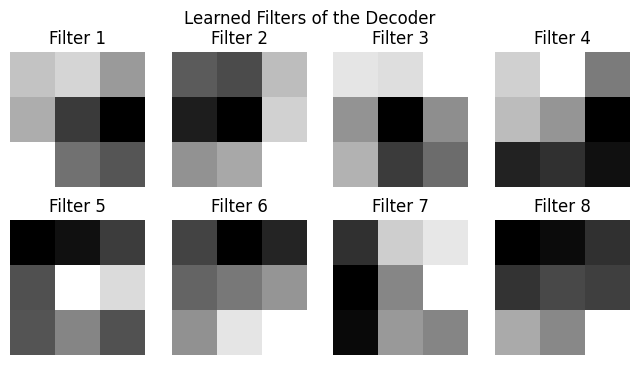

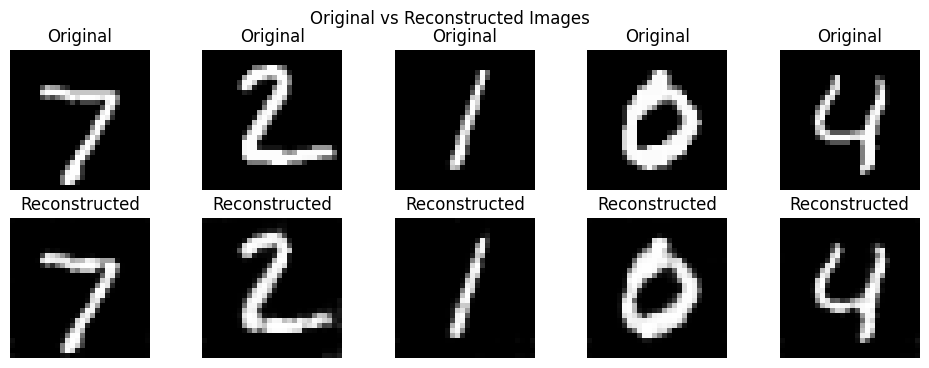

In [32]:
def visualize_decoder_weights(model):
    with torch.no_grad():
        fig, axes = plt.subplots(2, 4, figsize=(8, 4))
        for i, ax in enumerate(axes.flat):
            ax.imshow(model.decoder_conv1.weight[i, 0].cpu().numpy(), cmap='gray')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')
        plt.suptitle('Learned Filters of the Decoder')
        plt.show()

# Visualize the learned filters
visualize_decoder_weights(model)

# Test the convolutional autoencoder on a test image
test_convolutional_autoencoder(model, test_loader)
